In [13]:
%load_ext autoreload
%autoreload 2
%cd /group/transreg/sathi/DeepDifE 

import pickle
import importlib
import esparto
import optuna
import numpy as np
import pandas as pd
from evoaug_tf import evoaug, augment
from src.diff_expression_model import get_model, get_siamese_model, post_hoc_conjoining, get_auroc, load_model
from src.prepare_dataset import one_hot_encode_series, reverse_complement_series
from skopt.utils import use_named_args

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/storage/nas6/group/biocomp/projects/transreg/sathi/DeepDifE


## Start from weights from Helder

In [3]:
model_path = "/group/transreg/heopd/dlpipe/code/Sander/models/solid_chrome_model/model_single.json"
weights_path = "/group/transreg/heopd/dlpipe/code/Sander/models/solid_chrome_model/weights_single.h5"

model = load_model(model_path, weights_path)
model.inputs[0].shape[1]

augment_list = [
    augment.RandomRC(rc_prob=0.5),
    augment.RandomInsertionBatch(insert_min=0, insert_max=20),
    augment.RandomDeletion(delete_min=0, delete_max=30),
    augment.RandomTranslocationBatch(shift_min=0, shift_max=20),
    augment.RandomMutation(mutate_frac=0.05),
    augment.RandomNoise()
]

evoaug_model = evoaug.RobustModel(model, augment_list=augment_list)
siamese_model = get_siamese_model(model)


2024-07-05 17:58:14.365481: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/shared/apps/x86_64/dependencies_rl9:/software/shared/apps/x86_64/git/2.13.1/lib64/
2024-07-05 17:58:14.365847: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-05 17:58:14.366167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cyclone4.psblocal): /proc/driver/nvidia/version does not exist



Loaded model from disk


## Load dataframe containing LFC

In [4]:
import pandas as pd
genes_LFC_pd = pd.read_csv("/group/transreg/heopd/dlpipe/code/Sander/data/promotors/geneID_LFC_up_non.csv")
genes_LFC_pd.rename(columns={"set":"label"}, inplace=True)

In [5]:
genes_LFC_pd

,geneID,LFC,padj,label,gene_symbol
0,AT1G07430,13.56,0.0,up,"['HAI2', 'HON', 'AtAIP1', 'AIP1']"
1,AT3G51895,13.32,0.0,up,"['AST12', 'SULTR3;1']"
2,AT1G04560,12.71,0.0,up,['no symbol available']
3,AT2G40170,12.14,0.0,up,"['GEA6', 'EM6', 'ATEM6']"
4,AT5G52300,12.02,0.0,up,"['RD29B', 'LTI65']"
...,...,...,...,...,...
15193,AT5G11590,-8.21,0.0,na,"['ERF041', 'TINY2']"
15194,AT2G40330,-8.36,0.0,na,"['RCAR9', 'PYL6']"
15195,AT1G06830,-8.48,0.0,na,"['ROXY6', 'CEPD1']"
15196,AT3G27950,-8.92,0.0,na,['no symbol available']


In [72]:
genes_LFC_pd

,geneID,LFC,padj,label,gene_symbol
0,AT1G07430,13.56,0.0,up,"['HAI2', 'HON', 'AtAIP1', 'AIP1']"
1,AT3G51895,13.32,0.0,up,"['AST12', 'SULTR3;1']"
2,AT1G04560,12.71,0.0,up,['no symbol available']
3,AT2G40170,12.14,0.0,up,"['GEA6', 'EM6', 'ATEM6']"
4,AT5G52300,12.02,0.0,up,"['RD29B', 'LTI65']"
...,...,...,...,...,...
15193,AT5G11590,-8.21,0.0,na,"['ERF041', 'TINY2']"
15194,AT2G40330,-8.36,0.0,na,"['RCAR9', 'PYL6']"
15195,AT1G06830,-8.48,0.0,na,"['ROXY6', 'CEPD1']"
15196,AT3G27950,-8.92,0.0,na,['no symbol available']


### Check the LFC used to create the train test set of 2400

In [77]:
genes_LFC_pd.label.value_counts()

na     12798
up      1200
non     1200
Name: label, dtype: int64

In [80]:
print(f" Lowest LFC in the UP set: {genes_LFC_pd[genes_LFC_pd.label == 'up'].LFC.min()}")

 Lowest LFC in the UP set: 1.32


## Find the sequences, prepare and predict

In [7]:
from Bio import SeqIO

sequence_list = []
gene_id_list = []
for chunk in range(1,201):
	fasta_path = f"/group/transreg/heopd/dlpipe/code/Sander/data/promotors/chunked/promsFromGetfasta_500up100down.fa_c{chunk}"
	fasta_sequences = SeqIO.parse(open(fasta_path),'fasta')
	
	for fasta in fasta_sequences:
		name, sequence = fasta.id, str(fasta.seq)
		name = name.split(":")[0]
		if name in list(genes_LFC_pd.geneID):
			gene_id_list.append(name)
			sequence_list.append(sequence)

In [12]:
ohe_df = one_hot_encode_series(pd.Series(sequence_list))

In [14]:
rc_ohe_df = reverse_complement_series(ohe_df)

In [19]:
ohe_np = np.stack(ohe_df)
rc_ohe_np = np.stack(rc_ohe_df)

In [20]:
ohe_np = evoaug_model._pad_end(ohe_np)
rc_ohe_np = evoaug_model._pad_end(rc_ohe_np)

In [21]:
predictions_categories, predictions = post_hoc_conjoining(siamese_model, ohe_np, rc_ohe_np)


475/475 [==============================] - 32s 67ms/step


Create df containing the geneIDs and their predictions

In [23]:
prediction_df = pd.DataFrame({"geneID": gene_id_list, "promotor_prediction": predictions})

## Label the greyzone

In [253]:
promotor_prediction_df = pd.merge(prediction_df, genes_LFC_pd, how="inner")

In [254]:
promotor_prediction_df

,geneID,promotor_prediction,LFC,padj,label,gene_symbol
0,AT3G10940,0.069546,0.40,0.01,na,['LSF2']
1,AT3G18040,0.870054,0.97,0.00,na,['MPK9']
2,AT1G48110,0.202101,0.42,0.00,na,['ECT7']
3,AT5G15710,0.281345,0.28,0.18,na,['no symbol available']
4,AT3G05270,0.558580,0.59,0.00,na,['VETH1']
...,...,...,...,...,...,...
15192,AT1G63855,0.100398,0.31,0.88,na,['no symbol available']
15193,AT3G50590,0.078534,0.17,0.10,na,['TWD40-1']
15194,AT3G44340,0.226678,0.16,0.15,na,['CEF']
15195,AT1G63100,0.500387,-0.91,0.00,na,['SCL28']


In [255]:
promotor_prediction_df.label.value_counts()

na     12797
up      1200
non     1200
Name: label, dtype: int64

## Greyzone set 1

In [381]:
promotor_prediction_df = pd.merge(prediction_df, genes_LFC_pd, how="inner")
promotor_prediction_df.loc[(promotor_prediction_df["label"] == "na") & (promotor_prediction_df["padj"] < 0.05) & (promotor_prediction_df["LFC"] > 0.5), "label"] = "greyzone_up"
promotor_prediction_df.loc[(promotor_prediction_df["label"] == "na") & (promotor_prediction_df["padj"] > 0.1) & (promotor_prediction_df["LFC"] < 1), "label"] = "greyzone_non"

In [382]:
promotor_prediction_df.label.value_counts()

na              5888
greyzone_non    5295
greyzone_up     1614
up              1200
non             1200
Name: label, dtype: int64

In [383]:
promotor_prediction_df

,geneID,promotor_prediction,LFC,padj,label,gene_symbol
0,AT3G10940,0.069546,0.40,0.01,na,['LSF2']
1,AT3G18040,0.870054,0.97,0.00,greyzone_up,['MPK9']
2,AT1G48110,0.202101,0.42,0.00,na,['ECT7']
3,AT5G15710,0.281345,0.28,0.18,greyzone_non,['no symbol available']
4,AT3G05270,0.558580,0.59,0.00,greyzone_up,['VETH1']
...,...,...,...,...,...,...
15192,AT1G63855,0.100398,0.31,0.88,greyzone_non,['no symbol available']
15193,AT3G50590,0.078534,0.17,0.10,na,['TWD40-1']
15194,AT3G44340,0.226678,0.16,0.15,greyzone_non,['CEF']
15195,AT1G63100,0.500387,-0.91,0.00,na,['SCL28']


In [384]:
# grey_zone_definition = pd.read_csv("/group/transreg/heopd/dlpipe/code/Sander/data/grey_zone_labels.csv", delimiter=",")

## Analysis

In [385]:
promotor_prediction_df

,geneID,promotor_prediction,LFC,padj,label,gene_symbol
0,AT3G10940,0.069546,0.40,0.01,na,['LSF2']
1,AT3G18040,0.870054,0.97,0.00,greyzone_up,['MPK9']
2,AT1G48110,0.202101,0.42,0.00,na,['ECT7']
3,AT5G15710,0.281345,0.28,0.18,greyzone_non,['no symbol available']
4,AT3G05270,0.558580,0.59,0.00,greyzone_up,['VETH1']
...,...,...,...,...,...,...
15192,AT1G63855,0.100398,0.31,0.88,greyzone_non,['no symbol available']
15193,AT3G50590,0.078534,0.17,0.10,na,['TWD40-1']
15194,AT3G44340,0.226678,0.16,0.15,greyzone_non,['CEF']
15195,AT1G63100,0.500387,-0.91,0.00,na,['SCL28']


In [386]:
all_greys = promotor_prediction_df[promotor_prediction_df["label"].isin(["greyzone_up","greyzone_non"])]
grey_ups = promotor_prediction_df[promotor_prediction_df["label"] == "greyzone_up"]
grey_ups = promotor_prediction_df[promotor_prediction_df["label"] == "greyzone_up"]

In [387]:
train =  promotor_prediction_labeled[promotor_prediction_labeled["label"].isin(["up", "non"])]

In [388]:
all_greys.promotor_prediction.unique()

array([0.8700544 , 0.28134465, 0.5585796 , ..., 0.0862228 , 0.10039765,
       0.22667809], dtype=float32)

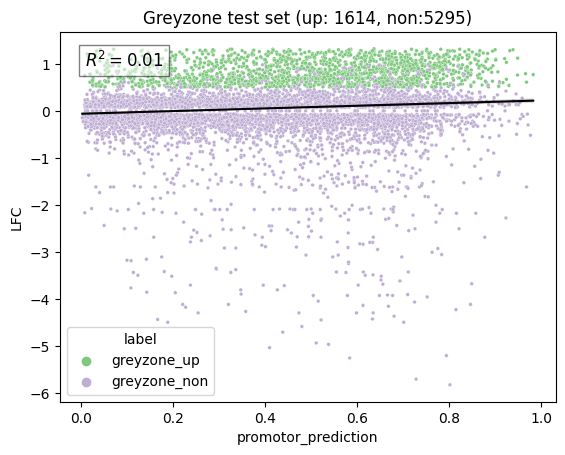

In [389]:
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

sns.scatterplot(data=all_greys, x='promotor_prediction', y='LFC', hue='label', hue_order=list(all_greys.label.unique()), palette='Accent', s=7)

# Plot the regression line without considering the hue (label)
sns.regplot(
    data=all_greys, 
    x='promotor_prediction', 
    y='LFC', 
    scatter=False,  # No scatter points here since we already plotted them
    color='black',  # Line color
    line_kws={'lw': 1.5}  # Line width
)

# Calculate Pearson correlation coefficient and R^2
pearson_corr, _ = pearsonr(all_greys['promotor_prediction'], all_greys['LFC'])
r_squared = pearson_corr ** 2

# Annotate the R^2 value on the plot
plt.annotate(f'$R^2 = {r_squared:.2f}$', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
             horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

up_count = all_greys[all_greys.label == 'greyzone_up'].shape[0]
non_count = all_greys[all_greys.label == 'greyzone_non'].shape[0]

plt.title(f"Greyzone test set (up: {up_count}, non:{non_count})")
# Show the plot
plt.show()

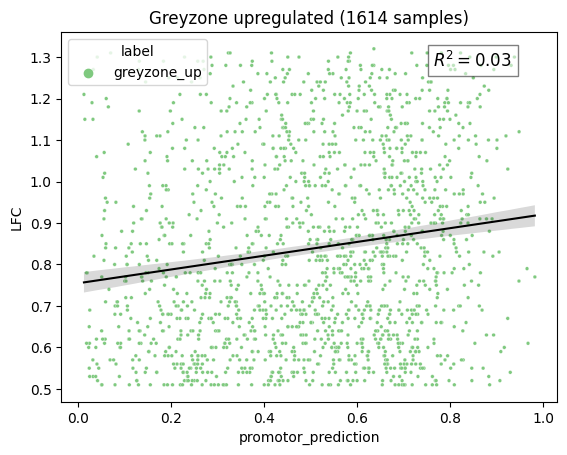

In [390]:
from scipy.stats import pearsonr

sns.scatterplot(data=grey_ups, x='promotor_prediction', y='LFC', hue='label', hue_order=list(grey_ups.label.unique()), palette='Accent', s=7)

# Plot the regression line without considering the hue (label)
sns.regplot(
    data=grey_ups, 
    x='promotor_prediction', 
    y='LFC', 
    scatter=False,  # No scatter points here since we already plotted them
    color='black',  # Line color
    line_kws={'lw': 1.5}  # Line width
)

# Calculate Pearson correlation coefficient and R^2
pearson_corr, _ = pearsonr(grey_ups['promotor_prediction'], grey_ups['LFC'])
r_squared = pearson_corr ** 2

# Annotate the R^2 value on the plot
plt.annotate(f'$R^2 = {r_squared:.2f}$', xy=(0.75, 0.95), xycoords='axes fraction', fontsize=12,
             horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

up_count = all_greys[all_greys.label == 'greyzone_up'].shape[0]

plt.title(f"Greyzone upregulated ({up_count} samples)")

# Show the plot
plt.show()

### Plot distribution

In [391]:
print(f"Mean prediction probability greyzone up: {all_greys[all_greys['label'] == 'greyzone_up']['promotor_prediction'].mean()}")

Mean prediction probability greyzone up: 0.49964436888694763


In [392]:
print(f"Mean prediction probability greyzone non: {all_greys[all_greys['label'] == 'greyzone_non']['promotor_prediction'].mean()}")

Mean prediction probability greyzone non: 0.3990640938282013


<Figure size 640x480 with 0 Axes>

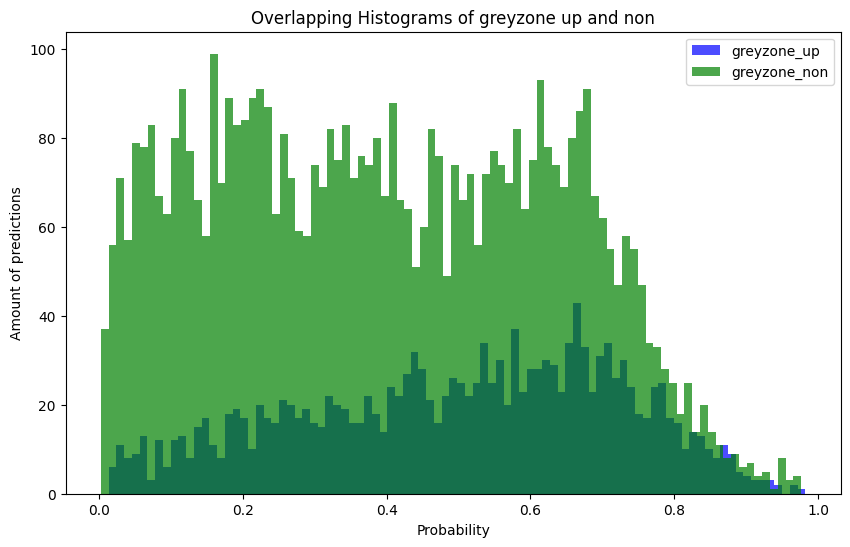

In [393]:

%matplotlib inline
import matplotlib.pyplot as plt
# Assuming scores_df is your DataFrame and you want to plot a histogram
plt.clf()
plt.figure(figsize=(10, 6))

# Plot histogram for Column1
plt.hist(all_greys[all_greys["label"] == "greyzone_up"]["promotor_prediction"], bins=90, color='blue', alpha=0.7, label='greyzone_up')

# Plot histogram for Column2
plt.hist(all_greys[all_greys["label"] == "greyzone_non"]["promotor_prediction"], bins=90, color='green', alpha=0.7, label='greyzone_non')

# Add title and labels
plt.title('Overlapping Histograms of greyzone up and non')
plt.xlabel('Probability')
plt.ylabel('Amount of predictions')

# Add legend
plt.legend(loc='upper right')
plt.show()

In [394]:
all_greys

,geneID,promotor_prediction,LFC,padj,label,gene_symbol
1,AT3G18040,0.870054,0.97,0.00,greyzone_up,['MPK9']
3,AT5G15710,0.281345,0.28,0.18,greyzone_non,['no symbol available']
4,AT3G05270,0.558580,0.59,0.00,greyzone_up,['VETH1']
5,AT5G55125,0.101401,-0.29,0.21,greyzone_non,['no symbol available']
8,AT1G48200,0.228856,-0.08,0.77,greyzone_non,['no symbol available']
...,...,...,...,...,...,...
15189,AT3G01750,0.715985,1.11,0.00,greyzone_up,['no symbol available']
15190,AT2G45130,0.372100,-1.56,0.80,greyzone_non,"['SPX3', 'ATSPX3']"
15191,AT3G02630,0.086223,0.09,0.61,greyzone_non,['AAD5']
15192,AT1G63855,0.100398,0.31,0.88,greyzone_non,['no symbol available']


In [395]:
grey_zone_promotor_predictions = list(all_greys["promotor_prediction"])
grey_zone_y_prediction = np.where(np.array(grey_zone_promotor_predictions) >= 0.5, 1, 0)
grey_zone_y_prediction

array([1, 0, 1, ..., 0, 0, 0])

In [396]:
grey_zone_promotor_labels = list(all_greys["label"])
grey_zone_y_true = np.where(np.array(grey_zone_promotor_labels) == "greyzone_up", 1, 0)
grey_zone_y_true


array([1, 0, 1, ..., 0, 0, 0])

In [397]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(grey_zone_y_true, grey_zone_y_prediction)
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(grey_zone_y_true, grey_zone_y_prediction)
print(f"Recall: {recall:.2f}")

# Calculate F1 score
f1 = f1_score(grey_zone_y_true, grey_zone_y_prediction)
print(f"F1 Score: {f1:.2f}")

Precision: 0.31
Recall: 0.54
F1 Score: 0.39


## Greyzone set 2

In [398]:
promotor_prediction_df = pd.merge(prediction_df, genes_LFC_pd, how="inner")
promotor_prediction_df.loc[(promotor_prediction_df["label"] == "na") & (promotor_prediction_df["padj"] < 0.05) & (promotor_prediction_df["LFC"] > 1.1), "label"] = "greyzone_up"
promotor_prediction_df.loc[(promotor_prediction_df["label"] == "na") & (promotor_prediction_df["padj"] > 0.1) & (promotor_prediction_df["LFC"] < 0.1) & (promotor_prediction_df["LFC"] > 0), "label"] = "greyzone_non"

In [399]:
promotor_prediction_df.label.value_counts()

na              12275
up               1200
non              1200
greyzone_up       274
greyzone_non      248
Name: label, dtype: int64

In [400]:
all_greys = promotor_prediction_df[promotor_prediction_df["label"].isin(["greyzone_up","greyzone_non"])]
grey_ups = promotor_prediction_df[promotor_prediction_df["label"] == "greyzone_up"]
grey_ups = promotor_prediction_df[promotor_prediction_df["label"] == "greyzone_up"]

In [401]:
train =  promotor_prediction_labeled[promotor_prediction_labeled["label"].isin(["up", "non"])]

In [402]:
all_greys.promotor_prediction.unique()

array([0.10720873, 0.4423063 , 0.6830853 , 0.7880863 , 0.5065927 ,
       0.34662795, 0.6852087 , 0.10403113, 0.63151217, 0.8442372 ,
       0.55199885, 0.5306281 , 0.6974691 , 0.6537688 , 0.5638112 ,
       0.5846443 , 0.5860468 , 0.6086987 , 0.55504787, 0.7947632 ,
       0.2952947 , 0.5253806 , 0.46064067, 0.4082296 , 0.16789302,
       0.6489502 , 0.60615   , 0.50183386, 0.5529934 , 0.4756348 ,
       0.41712525, 0.13773389, 0.62033397, 0.21951376, 0.12046449,
       0.03557297, 0.41387463, 0.05162711, 0.48582318, 0.6181004 ,
       0.27779144, 0.3182371 , 0.42814282, 0.44039077, 0.8189559 ,
       0.66639507, 0.41182408, 0.08441326, 0.5779129 , 0.04449314,
       0.6708173 , 0.6684936 , 0.438019  , 0.5663906 , 0.58313024,
       0.4245956 , 0.4207699 , 0.39171135, 0.50745356, 0.6803018 ,
       0.2936315 , 0.39083326, 0.18406436, 0.8336683 , 0.20007141,
       0.50402856, 0.1766963 , 0.8645388 , 0.7676548 , 0.44262195,
       0.76428854, 0.70773494, 0.5767878 , 0.3536427 , 0.62524

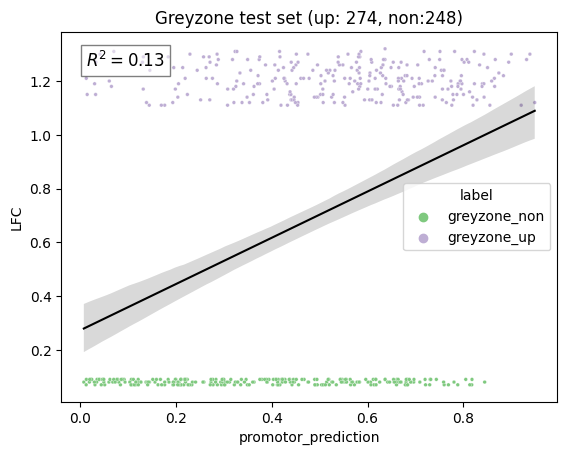

In [403]:
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

sns.scatterplot(data=all_greys, x='promotor_prediction', y='LFC', hue='label', hue_order=list(all_greys.label.unique()), palette='Accent', s=7)

# Plot the regression line without considering the hue (label)
sns.regplot(
    data=all_greys, 
    x='promotor_prediction', 
    y='LFC', 
    scatter=False,  # No scatter points here since we already plotted them
    color='black',  # Line color
    line_kws={'lw': 1.5}  # Line width
)

# Calculate Pearson correlation coefficient and R^2
pearson_corr, _ = pearsonr(all_greys['promotor_prediction'], all_greys['LFC'])
r_squared = pearson_corr ** 2

# Annotate the R^2 value on the plot
plt.annotate(f'$R^2 = {r_squared:.2f}$', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
             horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

up_count = all_greys[all_greys.label == 'greyzone_up'].shape[0]
non_count = all_greys[all_greys.label == 'greyzone_non'].shape[0]

plt.title(f"Greyzone test set (up: {up_count}, non:{non_count})")
# Show the plot
plt.show()

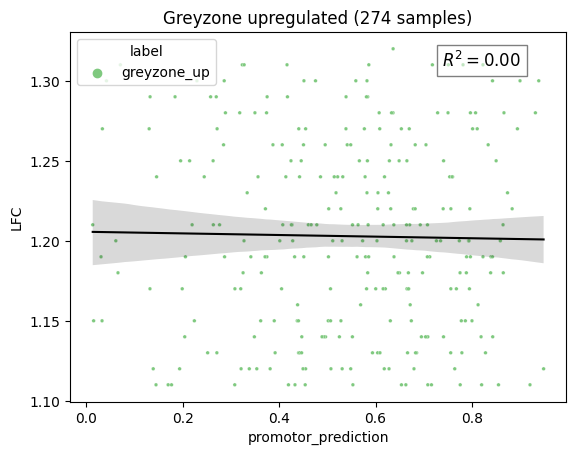

In [404]:
from scipy.stats import pearsonr

sns.scatterplot(data=grey_ups, x='promotor_prediction', y='LFC', hue='label', hue_order=list(grey_ups.label.unique()), palette='Accent', s=7)

# Plot the regression line without considering the hue (label)
sns.regplot(
    data=grey_ups, 
    x='promotor_prediction', 
    y='LFC', 
    scatter=False,  # No scatter points here since we already plotted them
    color='black',  # Line color
    line_kws={'lw': 1.5}  # Line width
)

# Calculate Pearson correlation coefficient and R^2
pearson_corr, _ = pearsonr(grey_ups['promotor_prediction'], grey_ups['LFC'])
r_squared = pearson_corr ** 2

# Annotate the R^2 value on the plot
plt.annotate(f'$R^2 = {r_squared:.2f}$', xy=(0.75, 0.95), xycoords='axes fraction', fontsize=12,
             horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

up_count = all_greys[all_greys.label == 'greyzone_up'].shape[0]

plt.title(f"Greyzone upregulated ({up_count} samples)")

# Show the plot
plt.show()

In [405]:
print(f"Mean prediction probability greyzone up: {all_greys[all_greys['label'] == 'greyzone_up']['promotor_prediction'].mean()}")

Mean prediction probability greyzone up: 0.542816698551178


In [406]:
print(f"Mean prediction probability greyzone non: {all_greys[all_greys['label'] == 'greyzone_non']['promotor_prediction'].mean()}")

Mean prediction probability greyzone non: 0.3719463348388672


<Figure size 640x480 with 0 Axes>

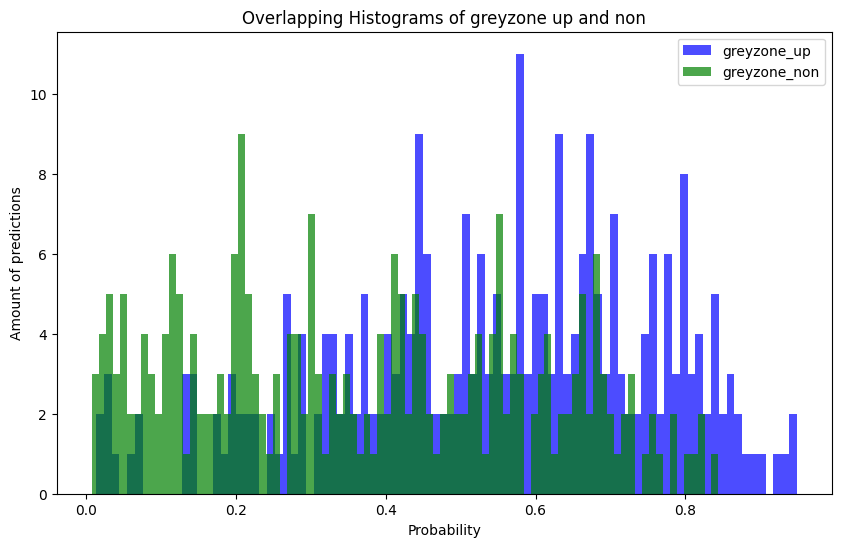

In [407]:

%matplotlib inline
import matplotlib.pyplot as plt
# Assuming scores_df is your DataFrame and you want to plot a histogram
plt.clf()
plt.figure(figsize=(10, 6))

# Plot histogram for Column1
plt.hist(all_greys[all_greys["label"] == "greyzone_up"]["promotor_prediction"], bins=90, color='blue', alpha=0.7, label='greyzone_up')

# Plot histogram for Column2
plt.hist(all_greys[all_greys["label"] == "greyzone_non"]["promotor_prediction"], bins=90, color='green', alpha=0.7, label='greyzone_non')

# Add title and labels
plt.title('Overlapping Histograms of greyzone up and non')
plt.xlabel('Probability')
plt.ylabel('Amount of predictions')

# Add legend
plt.legend(loc='upper right')
plt.show()

In [408]:
grey_zone_promotor_predictions = list(all_greys["promotor_prediction"])
grey_zone_y_prediction = np.where(np.array(grey_zone_promotor_predictions) >= 0.5, 1, 0)
grey_zone_y_prediction

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,

In [409]:
grey_zone_promotor_labels = list(all_greys["label"])
grey_zone_y_true = np.where(np.array(grey_zone_promotor_labels) == "greyzone_up", 1, 0)
grey_zone_y_true

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,

In [410]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(grey_zone_y_true, grey_zone_y_prediction)
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(grey_zone_y_true, grey_zone_y_prediction)
print(f"Recall: {recall:.2f}")

# Calculate F1 score
f1 = f1_score(grey_zone_y_true, grey_zone_y_prediction)
print(f"F1 Score: {f1:.2f}")

Precision: 0.67
Recall: 0.61
F1 Score: 0.64
